In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
from collections import defaultdict
from math import log

import einops
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
from pgmpy import estimators, inference, metrics, models
from pgmpy.factors.discrete import TabularCPD

import utils

In [3]:
df_train = pd.read_csv("dataset/coco2017-cooccurences-train.csv").iloc[:, 8:]
df_valid = pd.read_csv("dataset/coco2017-cooccurences-valid.csv").iloc[:, 8:]

In [31]:
df_train.values.max()

28

In [4]:
df_train.columns = [
    col.split("-")[0].replace("[", "").replace("]", "").title()
    for col in df_train.columns
]
df_valid.columns = df_train.columns

In [5]:
est = estimators.TreeSearch(df_train)
dag = est.estimate("chow-liu")

Building tree:   0%|          | 0/3160.0 [00:00<?, ?it/s]

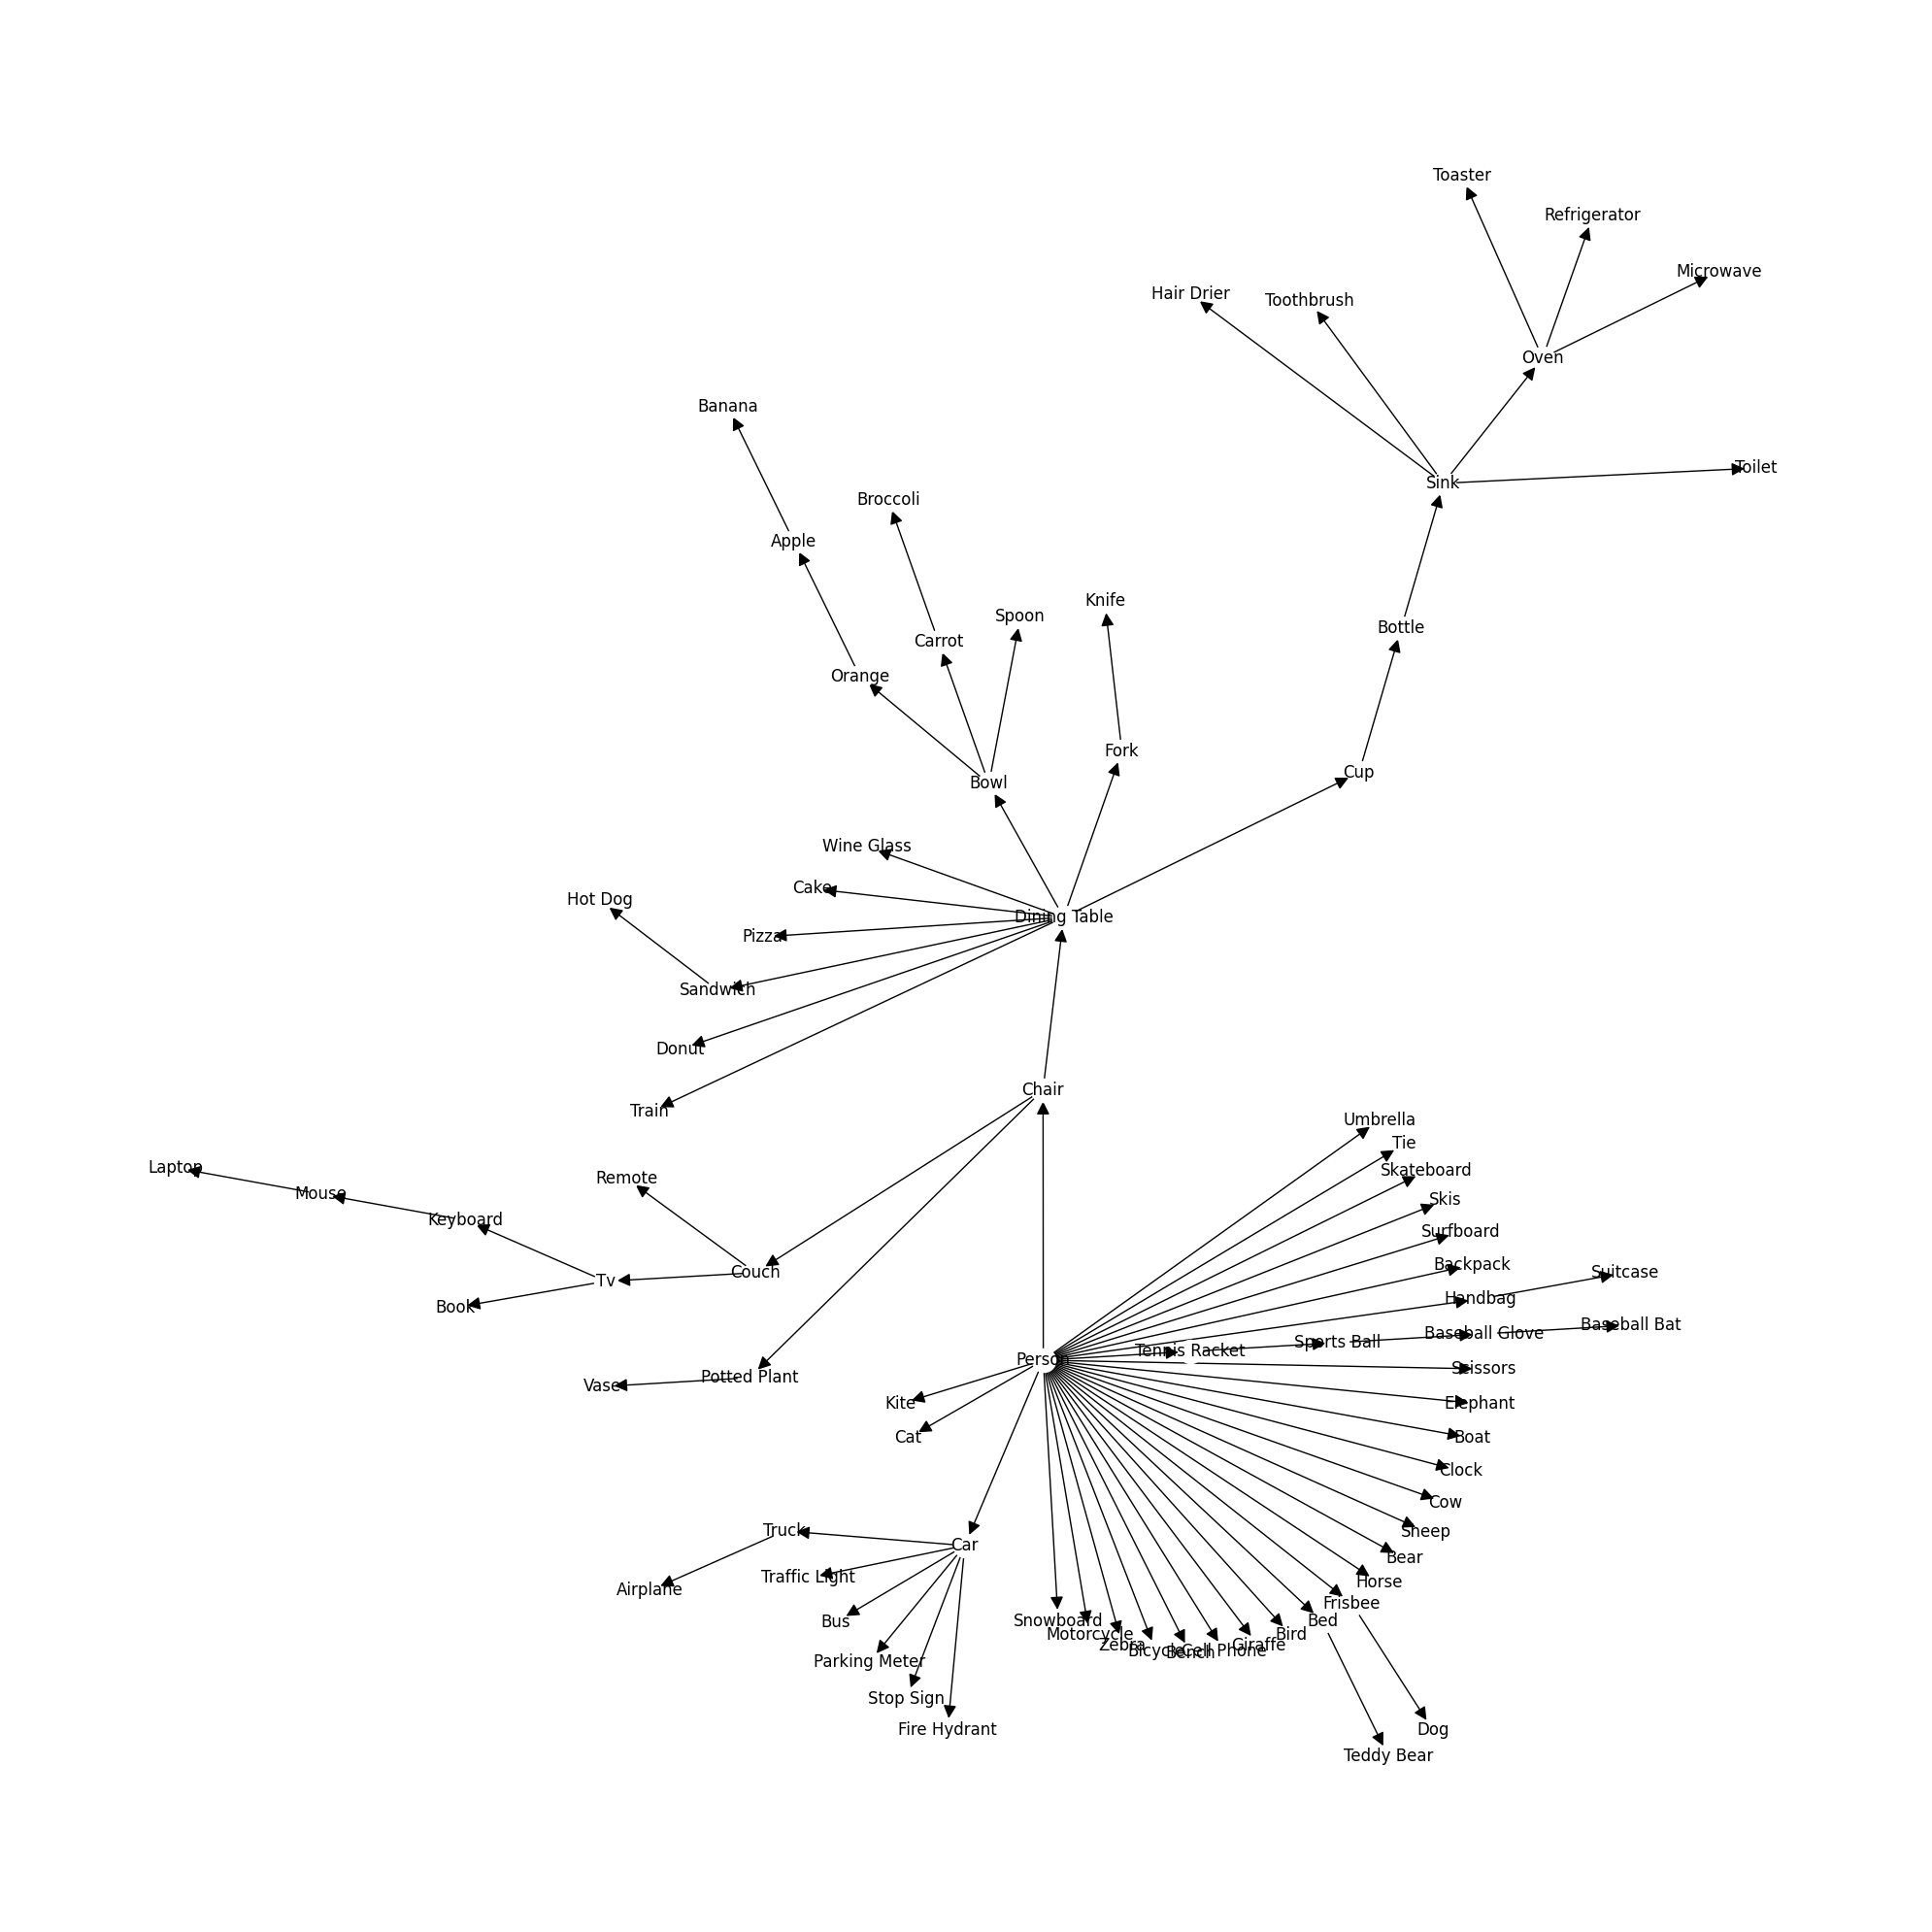

In [6]:
G = nx.Graph(dag)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
pos = nx.nx_agraph.graphviz_layout(dag, prog="twopi")
nx.draw_networkx(dag, pos, arrows=True, arrowsize=20, node_color="#FFFFFF")
ax.set_frame_on(False)
fig.tight_layout()
fig.savefig("outputs/chow-liu.pdf")

In [7]:
model = models.BayesianNetwork(dag)
model.fit(df_train, estimator=estimators.MaximumLikelihoodEstimator)
eps = 1e-10
param_count = 0
for n in range(len(model.cpds)):
    ids = model.cpds[n].no_to_name
    table = model.cpds[n].values
    table_new = torch.zeros([29] * len(ids))
    if len(ids) == 2:
        row, col = ids.values()
        for i, r in row.items():
            for j, c in col.items():
                table_new[r, c] = table[i, j]
    else:
        row = list(ids.values())[0]
        for i, r in row.items():
            table_new[r] = table[i]
        table_new = einops.repeat(table_new, "d -> d 1")
    table_new = (1 - eps) * table_new + eps / table_new.size(-1)
    table_new = table_new / table_new.sum(0, keepdims=True)
    table_new = table_new.numpy()
    param_count += table_new.size
    # break

    if len(ids) == 2:
        cpd = TabularCPD(
            model.cpds[n].variable,
            table_new.shape[0],
            table_new,
            model.cpds[n].get_evidence(),
            [table_new.shape[0]],
        )
    else:
        cpd = TabularCPD(model.cpds[n].variable, table_new.shape[0], table_new)

    model.cpds[n] = cpd

In [8]:
infer = metrics.BayesianModelProbability(model)
train_score = infer.log_probability(df_train)
valid_score = infer.log_probability(df_valid)

In [9]:
round(train_score.mean(), 4)

-13.4506

In [10]:
round(valid_score.mean(), 4)

-14.029

In [11]:
round(param_count * log(df_train.shape[0]) - 2 * train_score.sum(), 4)

3958454.443

In [12]:
model = models.BayesianNetwork(dag)
model.fit(df_train, estimator=estimators.MaximumLikelihoodEstimator)

param_count = 0

for cpd in model.get_cpds():
    param_count += cpd.values.size

In [13]:
round(param_count * log(df_train.shape[0]) - 2 * train_score.sum(), 4)

3405902.6085

In [15]:
infer = metrics.BayesianModelProbability(model)
train_score = infer.log_probability(df_train)
valid_score = infer.log_probability(df_valid)

/home/zarizky/mambaforge/envs/deep-learning/lib/python3.9/site-packages/pgmpy/metrics/bn_inference.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


KeyError: 15

In [29]:
((df_train == 15).any() == (df_valid == 15).any()).head(50)

Person            False
Bicycle           False
Car               False
Motorcycle        False
Airplane           True
Bus                True
Train              True
Truck              True
Boat              False
Traffic Light     False
Fire Hydrant       True
Stop Sign          True
Parking Meter      True
Bench              True
Bird               True
Cat                True
Dog                True
Horse             False
Sheep              True
Cow                True
Elephant          False
Bear               True
Zebra             False
Giraffe            True
Backpack           True
Umbrella          False
Handbag           False
Tie                True
Suitcase           True
Frisbee            True
Skis               True
Snowboard          True
Sports Ball        True
Kite              False
Baseball Bat       True
Baseball Glove     True
Skateboard         True
Surfboard          True
Tennis Racket      True
Bottle            False
Wine Glass        False
Cup             